In [2]:
import numpy as np
import pykrige
import pandas as pd
from osgeo import gdal
from glob import glob
import h5py
import pygrib
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from functools import partial
import multiprocessing

In [130]:
def clean(df, type='smap'):
    
    if type=='smap':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y%m%d')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        
    elif type=='noah':
        df.rename(columns= {'Unnamed: 0': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
        
    elif type=='meso':
        df= df.drop(0, axis=0)
        df.rename(columns= {'stnm': 'time'}, inplace=True)
        df.time= pd.to_datetime(df.time)
        df.sort_values(by='time', inplace=True)
        df.set_index('time', inplace=True)
        df.index= df.index.tz_localize('UTC').tz_convert('US/Central').tz_localize(None)
    
    
    df[df<0]= np.nan
    
    return df

def getIndex(lons,lats, lon, lat):
    col= np.where(abs(lons[0,:] - lon)== np.nanmin(abs(lons[0,:] - lon)))[0]
    row= np.where(abs(lats[:,0] - lat) == np.nanmin(abs(lats[:, 0] - lat)))[0]
                  
    return row, col

In [131]:
meso= clean(pd.read_csv('zhendata.csv', skiprows=1), 'meso')
smap= clean(pd.read_csv('SMAP_site_AM.csv'))

In [3]:
filePath = '/media/scratch/ZhiLi/SMAP/'
fnames= glob(filePath+'*.h5')
h5 = h5py.File('/media/scratch/ZhiLi/SMAP/SMAP_L3_SM_P_E_20150406_R16510_001.h5', 'r')

In [4]:
h5Lons= h5['Soil_Moisture_Retrieval_Data_AM/longitude'][:]
h5Lats= h5['Soil_Moisture_Retrieval_Data_AM/latitude'][:]
h5Lons[h5Lons<-200]=np.nan
h5Lats[h5Lats<-200]=np.nan

In [134]:
fnames= glob('data/*.grb')
gribs= pygrib.open(fnames[0])
grib= gribs.message(4)
lats, lons= grib.latlons()

In [66]:
smap.dropna(axis=0)

,110,1,2,116,135,111,126,6,8,9,...,99,100,101,102,132,104,105,106,107,108
time,,,,,,,,,,,,,,,,,,,,,
2015-04-06,0.218732,0.451987,0.176706,0.215839,0.346388,0.218434,0.250897,0.127881,0.061520,0.205494,...,0.214326,0.204706,0.218732,0.215839,0.389800,0.381491,0.334964,0.354043,0.176706,0.283774
2015-04-14,0.195978,0.380455,0.199409,0.124444,0.452057,0.156949,0.402512,0.211734,0.193801,0.173215,...,0.276550,0.133769,0.195978,0.124444,0.468672,0.460447,0.462988,0.464268,0.199409,0.419403
2015-04-22,0.179691,0.371073,0.129084,0.157690,0.434968,0.155998,0.382301,0.108926,0.086742,0.155559,...,0.272004,0.154751,0.179691,0.157690,0.452204,0.421143,0.393241,0.418448,0.129084,0.381430
2015-04-30,0.230678,0.366233,0.229723,0.227174,0.398219,0.232221,0.324448,0.246020,0.165771,0.226819,...,0.268032,0.228019,0.230678,0.227174,0.445353,0.460817,0.386358,0.462269,0.229723,0.353453
2015-05-08,0.330900,0.434527,0.339334,0.345212,0.443352,0.321140,0.374599,0.337812,0.263773,0.361730,...,0.337265,0.359737,0.330900,0.345212,0.411545,0.454999,0.434514,0.421712,0.339334,0.457300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29,0.226864,0.308874,0.233287,0.243589,0.312178,0.239643,0.256766,0.252525,0.180390,0.233494,...,0.217906,0.245436,0.226864,0.243589,0.349077,0.421395,0.321429,0.369986,0.233287,0.308825
2020-01-06,0.213052,0.312015,0.138005,0.169883,0.328392,0.197179,0.248957,0.173543,0.137168,0.158552,...,0.205504,0.186623,0.213052,0.169883,0.356128,0.451036,0.360822,0.405935,0.138005,0.309580
2020-01-14,0.181260,0.326993,0.106253,0.130483,0.368197,0.171674,0.260552,0.158644,0.128583,0.098265,...,0.197344,0.150957,0.184195,0.130483,0.328489,0.408127,0.329207,0.376279,0.106253,0.327709


In [72]:
getIndex(h5Lons, h5Lats, lons.max(), lats.min())

(array([361]), array([916]))

[
    (361,825)
    (323,916)
]

In [135]:
x= h5Lons[0,825:917]
y= h5Lats[323:361,100]

In [136]:
siteDF= pd.read_excel('Mesonet_Stations_info.xlsx')
siteDF.stnm= siteDF.stnm.astype(str)
siteDF.set_index('stnm', inplace=True)

In [89]:
siteDF.head()

,stid,name,city,rang,cdir,cnty,nlat,elon,elev,cdiv,...,A75,N75,BULK75,GRAV75,SAND75,SILT75,CLAY75,TEXT75,datc,datd
stnm,,,,,,,,,,,,,,,,,,,,,
110,ACME,Acme,Rush Springs,4.0,WNW,Grady,34.80833,-98.02325,397,Central,...,0.313,1.29,1.68,0,53.2,24.1,22.8,Sandy clay loam,19940101,20991231
1,ADAX,Ada,Ada,2.0,NNE,Pontotoc,34.79851,-96.66909,295,South Central,...,0.083,1.22,1.86,0,43.6,26.6,29.8,Clay loam,19940101,20991231
2,ALTU,Altus,Altus,3.0,S,Jackson,34.58722,-99.33808,416,Southwest,...,0.109,1.18,1.73,0,15.0,40.9,44.1,Silty clay,19940101,20991231
116,ALV2,Alva,Alva,7.2,SSW,Woods,36.70823,-98.70974,439,North Central,...,-999.000,-999.00,-999.00,-999,-999.0,-999.0,-999.0,-999,19981217,20991231
135,ANT2,Antlers,Antlers,3.0,WNW,Pushmataha,34.24967,-95.66844,172,Southeast,...,0.056,1.40,1.71,0,46.5,27.4,26.1,Sandy clay loam,20110415,20991231


In [137]:

def step(gridx, gridy, t):
    sites= meso.columns
    z= meso.loc[t,sites].values
    x= siteDF.loc[sites, 'elon'].values
    y= siteDF.loc[sites, 'nlat'].values
    x= x[~np.isnan(z)]
    y= y[~np.isnan(z)]
    z= z[~np.isnan(z)]    

    OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                     verbose=False, enable_plotting=False)
    z, ss =OK.execute('grid', gridx, gridy)
    z= np.asarray(z)
    rows, cols= z.shape
    arr= np.zeros((3,rows, cols))
    m,n= np.meshgrid(gridx,gridy)
    arr[0]= z.copy()
    arr[1]= n
    arr[2]= m
    np.save(t.strftime('regridedMESO/%Y%m%d%H.npy'), arr)
    
#     return z, ss

def main():
    global x, y
    slt= pd.date_range(start='2015-04-01 18:00:00', end="2019-07-02 18:00:00", freq='D')
    func= partial(step, x, y)
    with multiprocessing.Pool(20) as pool:
        pool.map(func, slt)


In [138]:
main()

# process gridded mesonet product

In [1]:
import netCDF4
from netCDF4 import num2date
from affine import Affine
from osgeo import gdal

In [45]:
def arr2raster(dst, arr, lons, lats):
    cols= arr.shape[1]
    rows= arr.shape[0]
    originX= lons[0]
    originY= lats[0]
    lon_diff= lons[1] - lons[0]
    lat_diff= lats[1]- lats[0]
    driver= gdal.GetDriverByName('GTiff')
    outdata= driver.Create(dst, cols, rows, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform((originX, lon_diff, 0, originY, 0, lat_diff))
    outdata.SetProjection('EPSG:4326')

    outdata.GetRasterBand(1).WriteArray(arr)
    print(arr.shape, cols, rows, originX, lon_diff,originY,lat_diff)
    
def getIndex(lons,lats, lon, lat):
    col= np.where(abs(lons[0,:] - lon)== np.nanmin(abs(lons[0,:] - lon)))[0]
    row= np.where(abs(lats[:,0] - lat) == np.nanmin(abs(lats[:, 0] - lat)))[0]
                  
    return row, col

In [3]:
sample= gdal.Open('/media/scratch/ZhiLi/Noah_6AM/20190702_0600.tif')
geo= sample.GetGeoTransform()

lons_ref= np.arange(geo[0], geo[0]+xsize*geo[1], geo[1])
lats_ref= np.arange(geo[3], geo[3]+ysize*geo[-1], geo[-1])

In [33]:
fname= 'data/NLDAS_NOAH0125_H.A%s.%s.002.grb.SUB.grb'%('20170101','0600')
gribs= pygrib.open(fname)
grib= gribs.message(4)
lats_ref, lons_ref= grib.latlons()
arr= grib.values
gribs.close()
xsize= lons_ref.shape[1]
ysize= lats_ref.shape[0]

In [58]:
with netCDF4.Dataset('/media/scratch/ZhiLi/OK_mesonet/gridded_SM_2017_2019.nc', 'r') as nc:
    lon= nc['lon'][:]
    lat= nc['lat'][:]
    time= nc['time'][:]
    timeUnits= nc.variables['time'].units
    date= num2date(time, timeUnits, calendar='standard')
    sm= nc['vwc'][:].filled(fill_value=-9999.)[:,0,:,:]

# a= Affine.from_gdal(lon[0,0], lon[0,1]-lon[0,0],0, lat[0,0],0,lat[1,0]-lat[0,0])

# new_arr= np.zeros((len(time),ysize, xsize))* -9999.
# for i in range(ysize):
#     for j in range(xsize):
#         _lon, _lat= lons_ref[i,j], lats_ref[i,j]
#         icol, irow= ~a * (_lon, _lat)
#         if _lon.max()>=_lon>=lon.min() and _lat.max()>=_lat>=lat.min():
#             new_arr[:,i,j]= sm[:, int(irow), int(icol)]
        
# for i, _date in enumerate(date):
#     fname= _date.strftime('/media/scratch/ZhiLi/Meso_gridded/%Y%m%d%H.tif')
#     arr2raster(fname, new_arr[i], lons_ref[0,:], lats_ref[:,0])

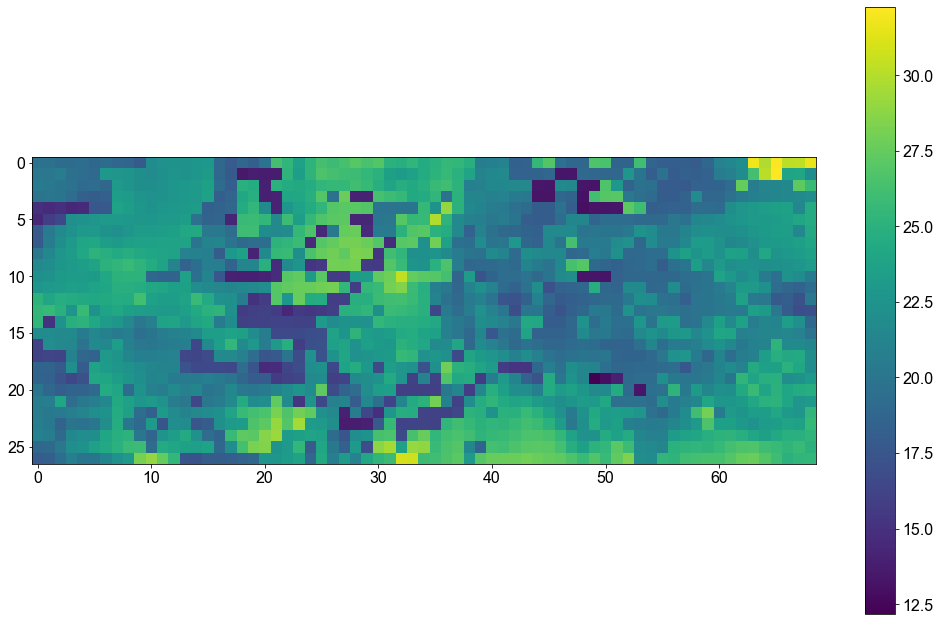

In [35]:
plt.imshow(arr);
plt.colorbar()

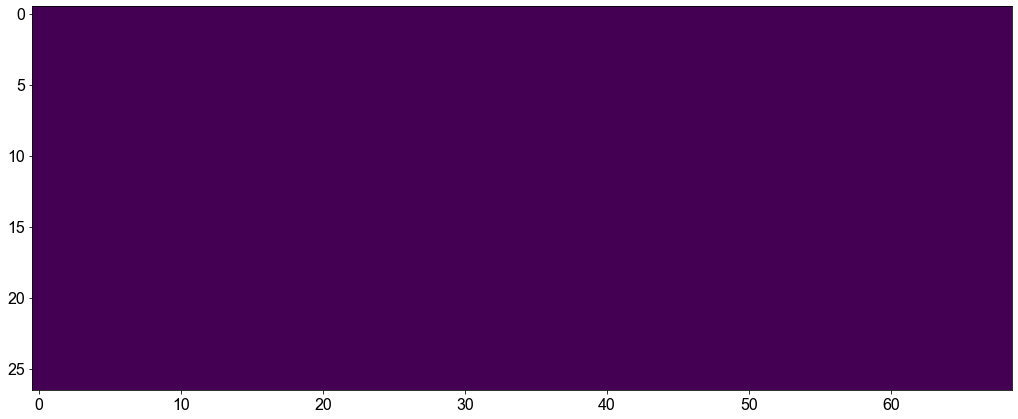

In [61]:
plt.imshow(gdal.Open('RMSE_NOAH_2020_05_21.tif').ReadAsArray())